In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pylab
import sys
# making sure the dl4mt module is on the path 
# -- this path depends upon the location where the notebook is running
# here it is assumed to be the day1/ directory
sys.path.append('../..')

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# use the stacked autoencoder for unsupervised pre-training, then fine tune parameters with a multilayer perceptron

import the autoencoder, logistic regression, and MLP classes saved in previous notebooks.

Evaluate the quality of our POS window vectors using the multilayer perceptron after a supervised fine tuning step. 

compare the performance of the classifier trained with the stacked autoencoder, vs single layer autoencoder

vs PCA

In [3]:
"""
 This tutorial introduces stacked denoising auto-encoders (SdA) using Theano.

 Denoising autoencoders are the building blocks for SdA.
 They are based on auto-encoders as the ones used in Bengio et al. 2007.
 An autoencoder takes an input x and first maps it to a hidden representation
 y = f_{\theta}(x) = s(Wx+b), parameterized by \theta={W,b}. The resulting
 latent representation y is then mapped back to a "reconstructed" vector
 z \in [0,1]^d in input space z = g_{\theta'}(y) = s(W'y + b').  The weight
 matrix W' can optionally be constrained such that W' = W^T, in which case
 the autoencoder is said to have tied weights. The network is trained such
 that to minimize the reconstruction error (the error between x and z).

 For the denosing autoencoder, during training, first x is corrupted into
 \tilde{x}, where \tilde{x} is a partially destroyed version of x by means
 of a stochastic mapping. Afterwards y is computed as before (using
 \tilde{x}), y = s(W\tilde{x} + b) and z as s(W'y + b'). The reconstruction
 error is now measured between z and the uncorrupted input x, which is
 computed as the cross-entropy :
      - \sum_{k=1}^d[ x_k \log z_k + (1-x_k) \log( 1-z_k)]


 References :
   - P. Vincent, H. Larochelle, Y. Bengio, P.A. Manzagol: Extracting and
   Composing Robust Features with Denoising Autoencoders, ICML'08, 1096-1103,
   2008
   - Y. Bengio, P. Lamblin, D. Popovici, H. Larochelle: Greedy Layer-Wise
   Training of Deep Networks, Advances in Neural Information Processing
   Systems 19, 2007

"""
import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

# import the classes that we created in previous notebooks
# from logistic_sgd import LogisticRegression, load_data

from dl4mt.logistic_regression import LogisticRegression
from dl4mt.mlp import HiddenLayer
from dl4mt.autoencoder_layer import dA

"""
 Most of this class was taken from the lisa-lab deeplearning tutorials 
 -- https://github.com/lisa-lab/DeepLearningTutorials

"""


class SdA(object):
    """Stacked denoising auto-encoder class (SdA)

    A stacked denoising autoencoder model is obtained by stacking several
    dAs. The hidden layer of the dA at layer `i` becomes the input of
    the dA at layer `i+1`. The first layer dA gets as input the input of
    the SdA, and the hidden layer of the last dA represents the output.
    Note that after pretraining, the SdA is dealt with as a normal MLP,
    the dAs are only used to initialize the weights.
    """
    
#     TODO: fix n_outs

    def __init__(
        self,
        numpy_rng,
        theano_rng=None,
        n_ins=784,
        hidden_layers_sizes=[500, 500],
        n_outs=10,
        corruption_levels=[0.1, 0.1]
    ):
        """ This class is made to support a variable number of layers.

        :type numpy_rng: numpy.random.RandomState
        :param numpy_rng: numpy random number generator used to draw initial
                    weights

        :type theano_rng: theano.tensor.shared_randomstreams.RandomStreams
        :param theano_rng: Theano random generator; if None is given one is
                           generated based on a seed drawn from `rng`

        :type n_ins: int
        :param n_ins: dimension of the input to the sdA

        :type n_layers_sizes: list of ints
        :param n_layers_sizes: intermediate layers size, must contain
                               at least one value

        :type n_outs: int
        :param n_outs: dimension of the output of the network

        :type corruption_levels: list of float
        :param corruption_levels: amount of corruption to use for each
                                  layer
        """

        self.sigmoid_layers = []
        self.dA_layers = []
        self.params = []
        self.n_layers = len(hidden_layers_sizes)

        assert self.n_layers > 0

        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))
        # allocate symbolic variables for the data
        self.x = T.matrix('x')  # the data is an embedding for each word
        self.y = T.ivector('y')  # the labels are presented as 1D vector of
                                 # [int] labels
            
        # The SdA is an MLP, for which all weights of intermediate layers
        # are shared with a different denoising autoencoders
        # We will first construct the SdA as a deep multilayer perceptron,
        # and when constructing each sigmoidal layer we also construct a
        # denoising autoencoder that shares weights with that layer
        # During pretraining we will train these autoencoders (which will
        # lead to chainging the weights of the MLP as well)
        # During finetunining we will finish training the SdA by doing
        # stochastich gradient descent on the MLP

        for i in xrange(self.n_layers):
            # construct the sigmoidal layer

            # the size of the input is either the number of hidden units of
            # the layer below or the input size if we are on the first layer
            if i == 0:
                input_size = n_ins
            else:
                input_size = hidden_layers_sizes[i - 1]

            # the input to this layer is either the activation of the hidden
            # layer below or the input of the SdA if you are on the first
            # layer
            if i == 0:
                layer_input = self.x
            else:
                layer_input = self.sigmoid_layers[-1].output

            sigmoid_layer = HiddenLayer(rng=numpy_rng,
                                        input=layer_input,
                                        n_in=input_size,
                                        n_out=hidden_layers_sizes[i],
                                        activation=T.nnet.sigmoid)

            # add the layer to our list of layers
            self.sigmoid_layers.append(sigmoid_layer)
            # its arguably a philosophical question...
            # but we are going to only declare that the parameters of the
            # sigmoid_layers are parameters of the StackedDAA
            # the visible biases in the dA are parameters of those
            # dA, but not the SdA
            self.params.extend(sigmoid_layer.params)

            # Construct a denoising autoencoder that shared weights with this
            # layer
            dA_layer = dA(numpy_rng=numpy_rng,
                          theano_rng=theano_rng,
                          input=layer_input,
                          n_visible=input_size,
                          n_hidden=hidden_layers_sizes[i],
                          W=sigmoid_layer.W, # this is the part that connects the MLP and Autoencoder
                          bhid=sigmoid_layer.b)
            self.dA_layers.append(dA_layer)

            
        # We now need to add a logistic layer on top of the MLP
        self.logLayer = LogisticRegression(
            input=self.sigmoid_layers[-1].output,
            n_in=hidden_layers_sizes[-1],
            n_out=n_outs
        )
        
        # alias to self.logLayer.y_pred for consistent interface
        self.y_pred = self.logLayer.y_pred

        self.params.extend(self.logLayer.params)
        # construct a function that implements one step of finetunining

        # compute the cost for second phase of training, defined as the negative log likelihood
        # in other words, use the "MLP view"
        self.finetune_cost = self.logLayer.negative_log_likelihood(self.y)
        
        # compute the gradients with respect to the model parameters
        # symbolic variable that points to the number of errors made on the
        # minibatch given by self.x and self.y
        self.errors = self.logLayer.errors(self.y)
        
    def get_embedding(self, X):
        for layer in self.dA_layers:
            X = layer.predict(X)
        return X
    
    def predict(self, X):
        for layer in self.dA_layers:
            X = layer.predict(X)
        y_hat = T.argmax(self.logLayer.predict(X), axis=1)
#         y_T.argmax(self.p_y_given_x, axis=1)
        return y_hat

    def pretraining_functions(self, train_set_x, batch_size):
        ''' Generates a list of functions, each of them implementing one
        step in trainnig the dA corresponding to the layer with same index.
        The function will require as input the minibatch index, and to train
        a dA you just need to iterate, calling the corresponding function on
        all minibatch indexes.

        :type train_set_x: theano.tensor.TensorType
        :param train_set_x: Shared variable that contains all datapoints used
                            for training the dA

        :type batch_size: int
        :param batch_size: size of a [mini]batch

        :type learning_rate: float
        :param learning_rate: learning rate used during training for any of
                              the dA layers
        '''

        # index to a [mini]batch
        index = T.lscalar('index')  # index to a minibatch
        corruption_level = T.scalar('corruption')  # % of corruption to use
        learning_rate = T.scalar('lr')  # learning rate to use
        # begining of a batch, given `index`
        batch_begin = index * batch_size
        # ending of a batch given `index`
        batch_end = batch_begin + batch_size

        pretrain_fns = []
        for dA in self.dA_layers:
            # get the cost and the updates list
            cost, updates = dA.get_cost_updates(corruption_level,
                                                learning_rate)
            # compile the theano training function
            fn = theano.function(
                inputs=[
                    index,
                    theano.Param(corruption_level, default=0.2),
                    theano.Param(learning_rate, default=0.1)
                ],
                outputs=cost,
                updates=updates,
                givens={
                    self.x: train_set_x[batch_begin: batch_end]
                }
            )
            # append `fn` to the list of functions
            pretrain_fns.append(fn)

        return pretrain_fns

    def build_finetune_functions(self, datasets, batch_size, learning_rate):
        '''Generates a function `train` that implements one step of
        finetuning, a function `validate` that computes the error on
        a batch from the validation set, and a function `test` that
        computes the error on a batch from the testing set

        :type datasets: list of pairs of theano.tensor.TensorType
        :param datasets: It is a list that contain all the datasets;
                         the has to contain three pairs, `train`,
                         `valid`, `test` in this order, where each pair
                         is formed of two Theano variables, one for the
                         datapoints, the other for the labels

        :type batch_size: int
        :param batch_size: size of a minibatch

        :type learning_rate: float
        :param learning_rate: learning rate used during finetune stage
        '''

#         TODO: use our dataset loading funcs
        (train_set_x, train_set_y) = datasets[0]
        (valid_set_x, valid_set_y) = datasets[1]
        (test_set_x, test_set_y) = datasets[2]

        # compute number of minibatches for training, validation and testing
        n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
        n_valid_batches /= batch_size
        n_test_batches = test_set_x.get_value(borrow=True).shape[0]
        n_test_batches /= batch_size

        index = T.lscalar('index')  # index to a [mini]batch

        # compute the gradients with respect to the model parameters
        gparams = T.grad(self.finetune_cost, self.params)

        # compute list of fine-tuning updates
        updates = [
            (param, param - gparam * learning_rate)
            for param, gparam in zip(self.params, gparams)
        ]

        train_fn = theano.function(
            inputs=[index],
            outputs=self.finetune_cost,
            updates=updates,
            givens={
                self.x: train_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: train_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            },
            name='train'
        )

        test_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: test_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: test_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            },
            name='test'
        )

        valid_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: valid_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: valid_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            },
            name='valid'
        )

        # Create a function that scans the entire validation set
        def valid_score():
            return [valid_score_i(i) for i in xrange(n_valid_batches)]

        # Create a function that scans the entire test set
        def test_score():
            return [test_score_i(i) for i in xrange(n_test_batches)]

        return train_fn, valid_score, test_score



In [4]:
def test_SdA(finetune_lr=0.1, pretraining_epochs=15,
             pretrain_lr=0.001, training_epochs=1000,
             dataset='mnist.pkl.gz', batch_size=1):
    """
    Demonstrates how to train and test a stochastic denoising autoencoder.

    :type learning_rate: float
    :param learning_rate: learning rate used in the finetune stage
    (factor for the stochastic gradient)

    :type pretraining_epochs: int
    :param pretraining_epochs: number of epoch to do pretraining

    :type pretrain_lr: float
    :param pretrain_lr: learning rate to be used during pre-training

    :type n_iter: int
    :param n_iter: maximal number of iterations ot run the optimizer

    :type dataset: string
    :param dataset: path the the pickled dataset

    """

    
    #         TODO: use our dataset loading
#     datasets = load_data(dataset)

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
    n_train_batches /= batch_size

    n_ins = train_set_x.get_value().shape[1]
    n_outs = 12
    
    # numpy random generator
    numpy_rng = numpy.random.RandomState(89677)
    print '... building the model'
    # construct the stacked denoising autoencoder class
    sda = SdA(
        numpy_rng=numpy_rng,
        n_ins=n_ins,
#         hidden_layers_sizes=[1000, 500, 100],
        hidden_layers_sizes=[1000, 500, 100, 2],
        n_outs=n_outs
    )

    #########################
    # PRETRAINING THE MODEL #
    #########################
    print '... getting the pretraining functions'
    pretraining_fns = sda.pretraining_functions(train_set_x=train_set_x,
                                                batch_size=batch_size)

    print '... pre-training the model'
    start_time = timeit.default_timer()
    
    ## Pre-train layer-wise
    # TODO: move this into function parameterization
    corruption_levels = [.1, .2, .3, .3]
#     corruption_levels = [.1, .2, .3]
    for i in xrange(sda.n_layers):
        # go through pretraining epochs
        for epoch in xrange(pretraining_epochs):
            # go through the training set
            c = []
            for batch_index in xrange(n_train_batches):
                c.append(pretraining_fns[i](index=batch_index,
                         corruption=corruption_levels[i],
                         lr=pretrain_lr))
            print 'Pre-training layer %i, epoch %d, cost ' % (i, epoch),
            print numpy.mean(c)

    end_time = timeit.default_timer()

    ########################
    # FINETUNING THE MODEL #
    ########################

    # get the training, validation and testing function for the model
    print '... getting the finetuning functions'
    train_fn, validate_model, test_model = sda.build_finetune_functions(
        datasets=datasets,
        batch_size=batch_size,
        learning_rate=finetune_lr
    )

    print '... finetuning the model'
    # early-stopping parameters
    patience = 10 * n_train_batches  # look as this many examples regardless
    patience_increase = 2.  # wait this much longer when a new best is
                            # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
    validation_frequency = min(n_train_batches, patience / 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    test_score = 0.
    start_time = timeit.default_timer()

    done_looping = False
    epoch = 0

    while (epoch < training_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in xrange(n_train_batches):
            minibatch_avg_cost = train_fn(minibatch_index)
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                validation_losses = validate_model()
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f %%' %
                      (epoch, minibatch_index + 1, n_train_batches,
                       this_validation_loss * 100.))

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:

                    #improve patience if loss improvement is good enough
                    if (
                        this_validation_loss < best_validation_loss *
                        improvement_threshold
                    ):
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = test_model()
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print(
        (
            'Optimization complete with best validation score of %f %%, '
            'on iteration %i, '
            'with test performance %f %%'
        )
        % (best_validation_loss * 100., best_iter + 1, test_score * 100.)
    )

    return sda

In [18]:
import os

from dl4mt.datasets import prep_dataset
from dl4mt.training import train_model

# location of our datasets
DATASET_LOCATION = '../../datasets/'

# the pos dataset consists of windows around words
POS_DATASET_NAME = 'brown_pos_dataset.hdf5'
POS_DATASET_PATH = os.path.join(DATASET_LOCATION, POS_DATASET_NAME)
WORD_BY_WORD_MATRIX = 'brown.word-by-word.normalized.npy'
VECTOR_INDEX_PATH = os.path.join(DATASET_LOCATION, WORD_BY_WORD_MATRIX)

# the cutoff for the maximum number of training and dev examples
CUTOFF = 10000
  
train_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['train'], cutoff=CUTOFF)
dev_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['dev'], cutoff=CUTOFF)
test_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['test'], cutoff=CUTOFF)
datasets = (train_dataset, dev_dataset, test_dataset)
    
classifier = test_SdA(dataset=datasets, pretraining_epochs=5, training_epochs=15, batch_size=10)

... building the model
... getting the pretraining functions
... pre-training the model
Pre-training layer 0, epoch 0, cost  117.749
Pre-training layer 0, epoch 1, cost  88.2471
Pre-training layer 0, epoch 2, cost  80.386
Pre-training layer 0, epoch 3, cost  75.6427
Pre-training layer 0, epoch 4, cost  72.3739
Pre-training layer 1, epoch 0, cost  573.433
Pre-training layer 1, epoch 1, cost  518.511
Pre-training layer 1, epoch 2, cost  507.059
Pre-training layer 1, epoch 3, cost  501.045
Pre-training layer 1, epoch 4, cost  496.72
Pre-training layer 2, epoch 0, cost  237.247
Pre-training layer 2, epoch 1, cost  190.761
Pre-training layer 2, epoch 2, cost  172.859
Pre-training layer 2, epoch 3, cost  164.103
Pre-training layer 2, epoch 4, cost  159.143
Pre-training layer 3, epoch 0, cost  67.7894
Pre-training layer 3, epoch 1, cost  63.3709
Pre-training layer 3, epoch 2, cost  60.7176
Pre-training layer 3, epoch 3, cost  58.6121
Pre-training layer 3, epoch 4, cost  56.9635
... getting th

In [15]:
# For this part to make sense, the final autoencoder output dim needs to be = 2
# make a theano function to get predictions from a trained model
training_data = theano.tensor.matrix('training_X')

embeddings = classifier.get_embedding(training_data)

get_predictions = theano.function([training_data], embeddings)

In [16]:
# get predictions and evaluate
x_embeddings = get_predictions(train_dataset[0].get_value())

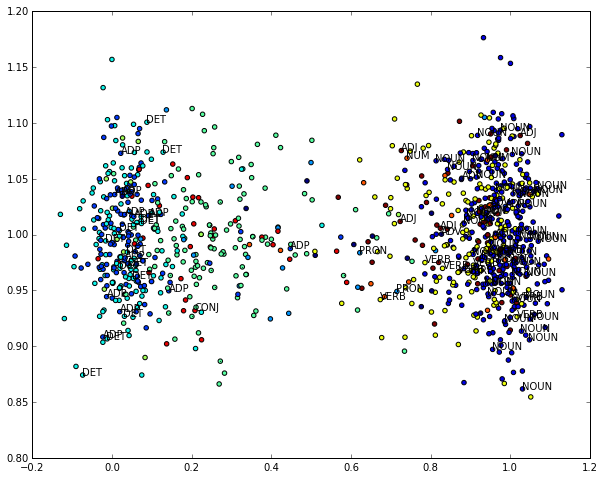

In [17]:
# uncomment if you want to be able to zoom and pan in a separate window
# %matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cPickle

# get train_y without the cast
train_y = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['train'],
                       cast_y=False, cutoff=CUTOFF)[1].get_value().astype('int32')

# -- this is the visualization cutoff (the number of examples to plot)
CUTOFF_BEGIN=0
CUTOFF_END=1000

CORPUS_INDICES = 'brown_pos_dataset.indices'
# Indexes for mapping words and tags <--> ints
with open(os.path.join(DATASET_LOCATION, CORPUS_INDICES)) as indices_file:
    corpus_indices = cPickle.load(indices_file)

y_vals = train_y[CUTOFF_BEGIN:CUTOFF_END]
y_class_names = [corpus_indices['idx2tag'][idx] for idx in y_vals]
norm_y_vals = y_vals / float(np.amax(y_vals))

jitter1 = np.random.normal(loc=0.0, scale=0.05, size=CUTOFF_END-CUTOFF_BEGIN)
jitter2 = np.random.normal(loc=0.0, scale=0.05, size=CUTOFF_END-CUTOFF_BEGIN)
x1 = x_embeddings[CUTOFF_BEGIN:CUTOFF_END,0] + jitter1
x2 = x_embeddings[CUTOFF_BEGIN:CUTOFF_END,1] + jitter2

fig, ax = plt.subplots()
# ax.scatter(z, y)

ax.scatter(x1, x2, c=norm_y_vals, s=20)
for i, txt in enumerate(zip(x1,x2)):
    if i % 10 == 0:
        ax.annotate(y_class_names[i], (x1[i],x2[i]))

# if you just want to show the plot without labels
# plt.scatter(x1, x2, c=norm_y_vals, s=20)
plt.show()

In [9]:
import cPickle
from dl4mt.predict import predict

test_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['test'], cutoff=CUTOFF, cast_y=False)

test_X, test_y = test_dataset
test_y = test_y.get_value().astype('int32')

testing_data = theano.tensor.matrix('test_X')
predictions = classifier.predict(testing_data)
get_predictions = theano.function([testing_data], predictions)
# get predictions and evaluate
predictions = get_predictions(test_dataset[0].get_value())

# map tag ids back to strings
y_test_actual = [corpus_indices['idx2tag'][tag_idx] for tag_idx in test_y]
y_test_hat = [corpus_indices['idx2tag'][tag_idx] for tag_idx in predictions]
# get class names
class_names = list(set(y_test_actual))

# quick precision check
sum([y==p for y,p in zip(predictions, test_y)]) / float(len(predictions))

0.34329999999999999

In [10]:
# let's take a look at the class distribution
from collections import Counter
c = Counter(y_test_actual)
num_items = len(y_test_actual)
class_distribution = {k:v/float(num_items) for k,v in c.items()}
class_distribution

{u'.': 0.1061,
 u'ADJ': 0.0725,
 u'ADP': 0.1304,
 u'ADV': 0.0396,
 u'CONJ': 0.0259,
 u'DET': 0.125,
 u'NOUN': 0.254,
 u'NUM': 0.0125,
 u'PRON': 0.0392,
 u'PRT': 0.0259,
 u'VERB': 0.1684,
 u'X': 0.0005}

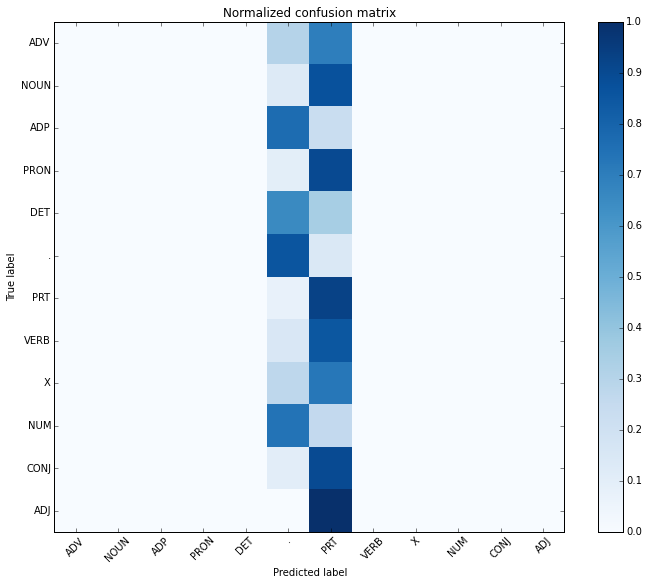

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test_actual, y_test_hat)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [ ]:
# Challenge: separate out the pre-training and fine-tuning steps
# and plot the 2-dimensional embedding after pretraining, then again after fine tuning

# Challenge: 